In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Apply Augumentation on train set

K-fold was initially used but later discarded due to its poor performance and high training time.

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 55.7 MB/s eta 0:00:00


##Augumentation layers

In [ ]:
import numpy as np
import os
import random
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import keras_cv

# Define the data augmentation pipeline
seed = 42

def cutmix_or_mixup(images, labels):
    samples = {"images": images, "labels": labels}
    if tf.random.uniform(()) > 0.5:
        augmented_samples = keras_cv.layers.CutMix(0.1)(samples)
        #augmented_samples = samples
    else:
        augmented_samples = keras_cv.layers.MixUp(0.1)(samples)
    return augmented_samples


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(factor=0.2, fill_mode='reflect'),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
    tf.keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='reflect'),  # Added translation
    tf.keras.layers.GaussianNoise(stddev=0.2),
    #keras_cv.layers.RandAugment(value_range=(0, 255), augmentations_per_image=1, magnitude=0.01, seed=seed),
    keras_cv.layers.RandomColorDegeneration(factor=0.5, seed=seed),
    keras_cv.layers.RandomSharpness(factor=0.5, value_range=(0, 255), seed=seed),
], name='data_augmentation')

#Apply Augumentation on all the dataset

Balance the dataset and then apply augumentation entirely.

Here we saved each class due to possible Colab issues.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import random

def ApplyAugmentation_AllImgsAug(dataset_path, output_path, start_class=0):
    """
    Balance the dataset by duplicating images and then apply augmentations to all images starting from a specific class.
    """
    def BalanceDataset(X, y):
        """Balance the dataset by duplicating images."""
        unique, counts = np.unique(y, return_counts=True)
        class_counts = dict(zip(unique, counts))
        max_count = max(class_counts.values())

        print("\nBalancing dataset:")
        for class_label, count in class_counts.items():
            print(f"- Class {class_label}: {count} images")

        balanced_data = {}
        for class_label in unique:
            class_images = X[y == class_label]
            original_count = len(class_images)
            num_duplicates_needed = max_count - original_count

            # Duplicate images
            if num_duplicates_needed > 0:
                duplicated_images = np.tile(class_images, (num_duplicates_needed // original_count + 1, 1, 1, 1))[:num_duplicates_needed]
                balanced_images = np.concatenate([class_images, duplicated_images], axis=0)
            else:
                balanced_images = class_images

            balanced_data[class_label] = balanced_images
            print(f"- Class {class_label}: Balanced to {len(balanced_images)} images")

        return balanced_data, max_count

    def AugmentDataset(balanced_data, unique_classes, output_path, start_class):
        """Apply augmentations (data augmentation first, then CutMix/MixUp) to all images starting from a specific class."""
        print("\nApplying augmentations to the dataset...")

        # Ensure the output path exists
        os.makedirs(output_path, exist_ok=True)

        for class_label, images in balanced_data.items():
            if class_label < start_class:
                print(f"Skipping class {class_label} (below start class {start_class})")
                continue

            augmented_images = []
            augmented_labels = []

            print(f"\nProcessing class {class_label}:")
            with tqdm(total=len(images), desc=f"Augmenting class {class_label}") as pbar:
                for idx in range(len(images)):
                    # Select two images for augmentation
                    selected_indices = random.choices(range(len(images)), k=2)
                    selected_images = [data_augmentation(tf.convert_to_tensor(images[i], dtype=tf.float32)).numpy() for i in selected_indices]
                    selected_images = tf.stack(selected_images, axis=0)
                    selected_labels = tf.one_hot([class_label] * 2, depth=len(unique_classes))

                    # Apply CutMix or MixUp
                    augmented_samples = cutmix_or_mixup(selected_images, selected_labels)
                    cutmix_image = augmented_samples["images"][0].numpy()
                    cutmix_label = augmented_samples["labels"][0].numpy()

                    # Append the augmented image and label
                    augmented_images.append(cutmix_image)
                    augmented_labels.append(np.argmax(cutmix_label))  # Convert one-hot back to class label
                    pbar.update(1)

            print(f"- Augmented images generated for class {class_label}: {len(augmented_images)}")

            # Save the augmented dataset for the current class
            augmented_images = np.array(augmented_images, dtype=np.uint8)
            augmented_labels = np.array(augmented_labels, dtype=np.uint8)
            output_file_path = os.path.join(output_path, f"full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced_{class_label}.npz")
            np.savez_compressed(output_file_path, images=augmented_images, labels=augmented_labels)
            print(f"Saved augmented dataset for class {class_label} to {output_file_path}")

    # Load the dataset
    data = np.load(dataset_path)
    X = data['images']
    y = data['labels'].flatten()

    # Step 1: Balance the dataset
    balanced_data, max_count = BalanceDataset(X, y)

    # Step 2: Apply augmentations and save per class starting from `start_class`
    unique_classes = np.unique(y)
    AugmentDataset(balanced_data, unique_classes, output_path, start_class)

    print("\nAll class-augmented datasets have been saved.")


**Run Apply Augumentation**

In [ ]:
#train_dataset = '/content/drive/MyDrive/Homework1/dataset/npz_NoTestSet/filtered_classes_noOutliears/train_set.npz'
train_dataset = '/content/drive/MyDrive/Homework1/dataset/npz/filtered_classes_noOutliears.npz'
output_folder = '/content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced'
#ApplyAugmentation_NewImgsAug(train_dataset, output_folder)
ApplyAugmentation_AllImgsAug(train_dataset, output_folder)


Balancing dataset:
- Class 0: 852 images
- Class 1: 2181 images
- Class 2: 1085 images
- Class 3: 2026 images
- Class 4: 849 images
- Class 5: 993 images
- Class 6: 2330 images
- Class 7: 1642 images
- Class 0: Balanced to 2330 images
- Class 1: Balanced to 2330 images
- Class 2: Balanced to 2330 images
- Class 3: Balanced to 2330 images
- Class 4: Balanced to 2330 images
- Class 5: Balanced to 2330 images
- Class 6: Balanced to 2330 images
- Class 7: Balanced to 2330 images

Applying augmentations to the dataset...

Processing class 0:


Augmenting class 0: 100%|██████████| 2330/2330 [05:11<00:00,  7.48it/s]


- Augmented images generated for class 0: 2330
Saved augmented dataset for class 0 to /content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced_0.npz

Processing class 1:


Augmenting class 1: 100%|██████████| 2330/2330 [05:05<00:00,  7.63it/s]


- Augmented images generated for class 1: 2330
Saved augmented dataset for class 1 to /content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced_1.npz

Processing class 2:


Augmenting class 2: 100%|██████████| 2330/2330 [05:00<00:00,  7.75it/s]


- Augmented images generated for class 2: 2330
Saved augmented dataset for class 2 to /content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced_2.npz

Processing class 3:


Augmenting class 3: 100%|██████████| 2330/2330 [04:58<00:00,  7.80it/s]


- Augmented images generated for class 3: 2330
Saved augmented dataset for class 3 to /content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced_3.npz

Processing class 4:


Augmenting class 4: 100%|██████████| 2330/2330 [04:57<00:00,  7.84it/s]


- Augmented images generated for class 4: 2330
Saved augmented dataset for class 4 to /content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced_4.npz

Processing class 5:


Augmenting class 5: 100%|██████████| 2330/2330 [04:56<00:00,  7.86it/s]


- Augmented images generated for class 5: 2330
Saved augmented dataset for class 5 to /content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced_5.npz

Processing class 6:


Augmenting class 6: 100%|██████████| 2330/2330 [04:56<00:00,  7.86it/s]


- Augmented images generated for class 6: 2330
Saved augmented dataset for class 6 to /content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced_6.npz

Processing class 7:


Augmenting class 7: 100%|██████████| 2330/2330 [04:56<00:00,  7.86it/s]


- Augmented images generated for class 7: 2330
Saved augmented dataset for class 7 to /content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced_7.npz

All class-augmented datasets have been saved.


## Unify Augment file

In [ ]:
import os
import numpy as np

def UnifyAugmentedFiles(input_path, output_file):
    # Check if the unified file already exists
    if os.path.exists(output_file):
        print(f"The unified dataset '{output_file}' already exists. Skipping unification.")
        return

    # Find all .npz files in the input directory
    npz_files = [os.path.join(input_path, file) for file in os.listdir(input_path) if file.endswith('.npz')]

    if not npz_files:
        print("No .npz files found in the specified directory.")
        return

    unified_images = []
    unified_labels = []

    print("\nUnifying datasets from the following files:")
    for file in npz_files:
        print(f"- {file}")
        # Load each .npz file and append its contents
        data = np.load(file)
        unified_images.append(data['images'])
        unified_labels.append(data['labels'])

    # Concatenate all the images and labels
    unified_images = np.concatenate(unified_images, axis=0)
    unified_labels = np.concatenate(unified_labels, axis=0)

    print("\nFinal unified dataset stats:")
    unique, counts = np.unique(unified_labels, return_counts=True)
    for class_label, count in zip(unique, counts):
        print(f"Class {class_label}: {count} images")

    # Save the unified dataset to a single .npz file
    np.savez_compressed(output_file, images=unified_images, labels=unified_labels)
    print(f"\nUnified dataset saved to {output_file}")

# Paths
output_folder = '/content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced'

unified_output_file = os.path.join(output_folder, "train_set_Unified.npz")

# Call the function
UnifyAugmentedFiles(input_path=output_folder, output_file=unified_output_file)



Unifying datasets from the following files:
- /content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced_0.npz
- /content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced_1.npz
- /content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced_2.npz
- /content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced_3.npz
- /content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/full_set_StrongAugmentation_W

##Apply Randomly some augumentationa and plot them


Applying augmentations and plotting images for each class...


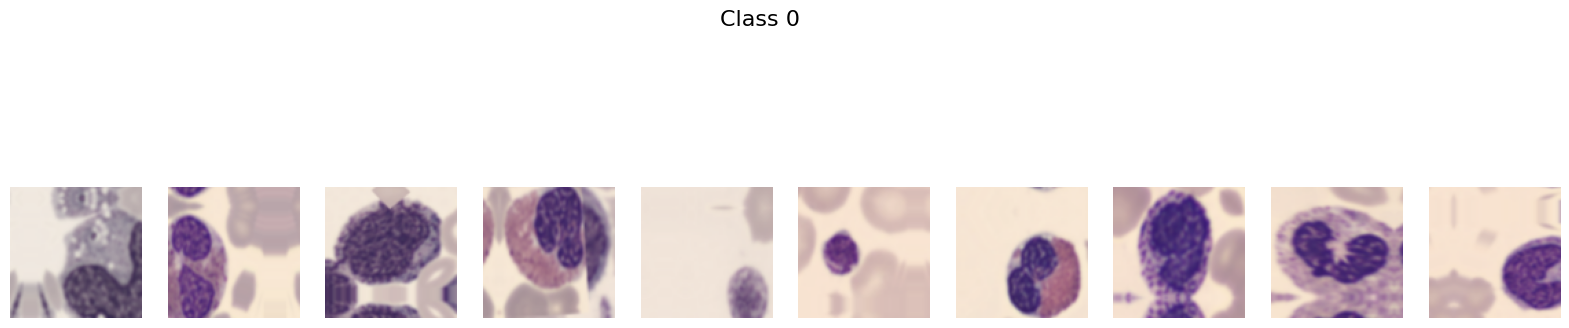

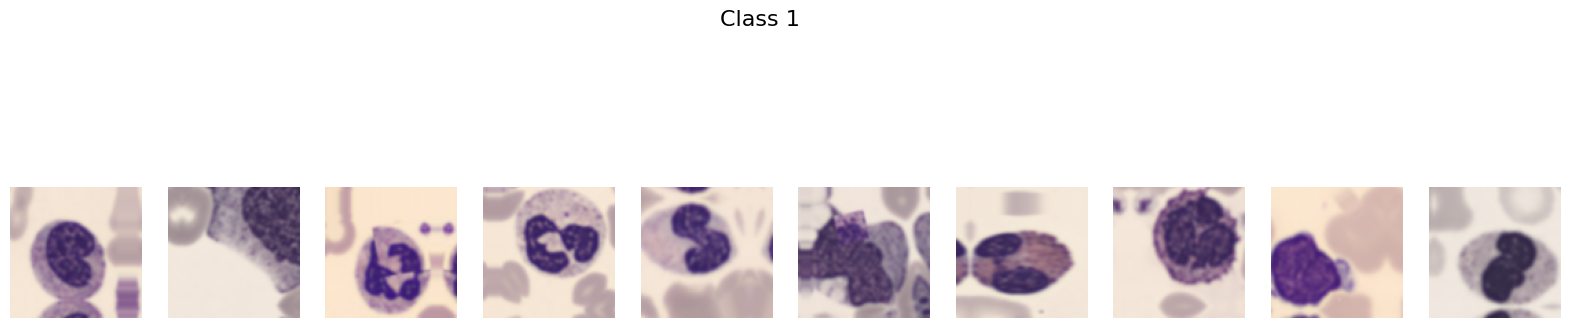

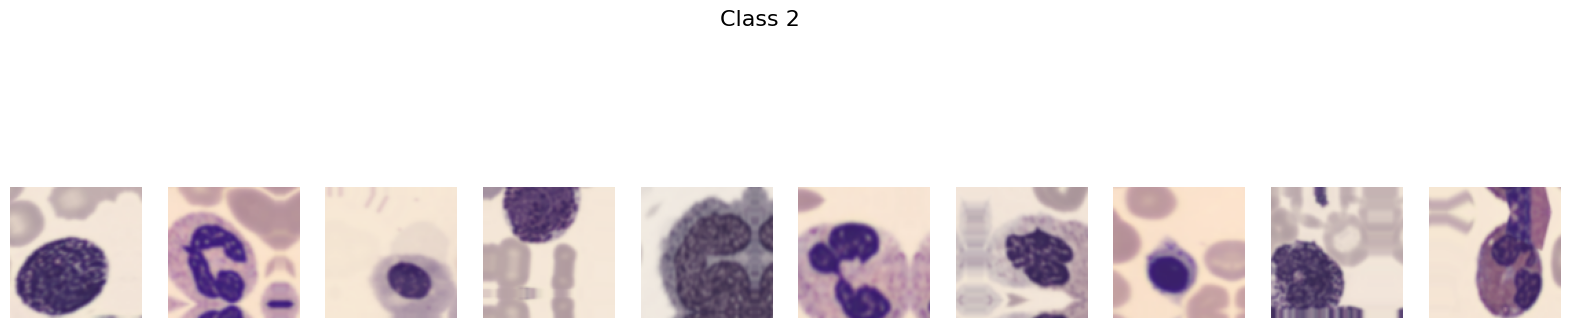

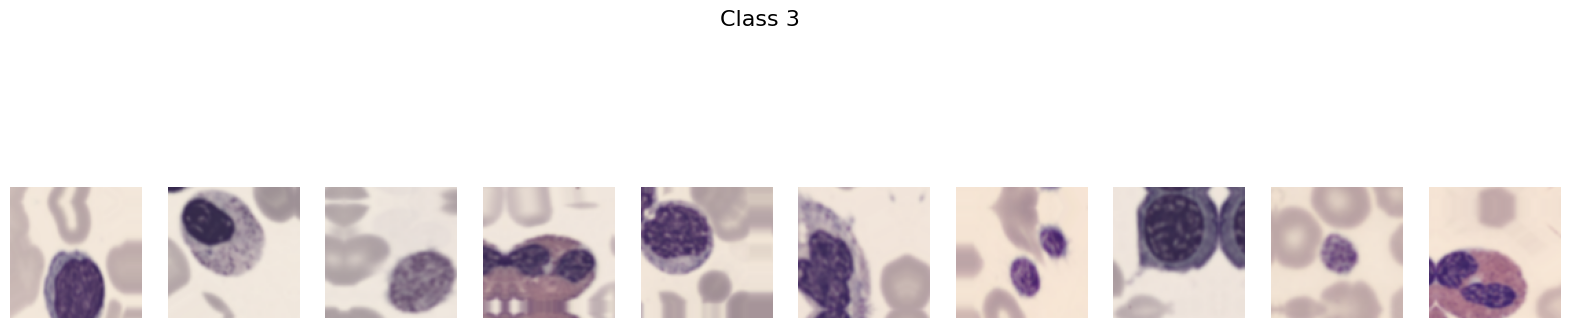

KeyboardInterrupt: 

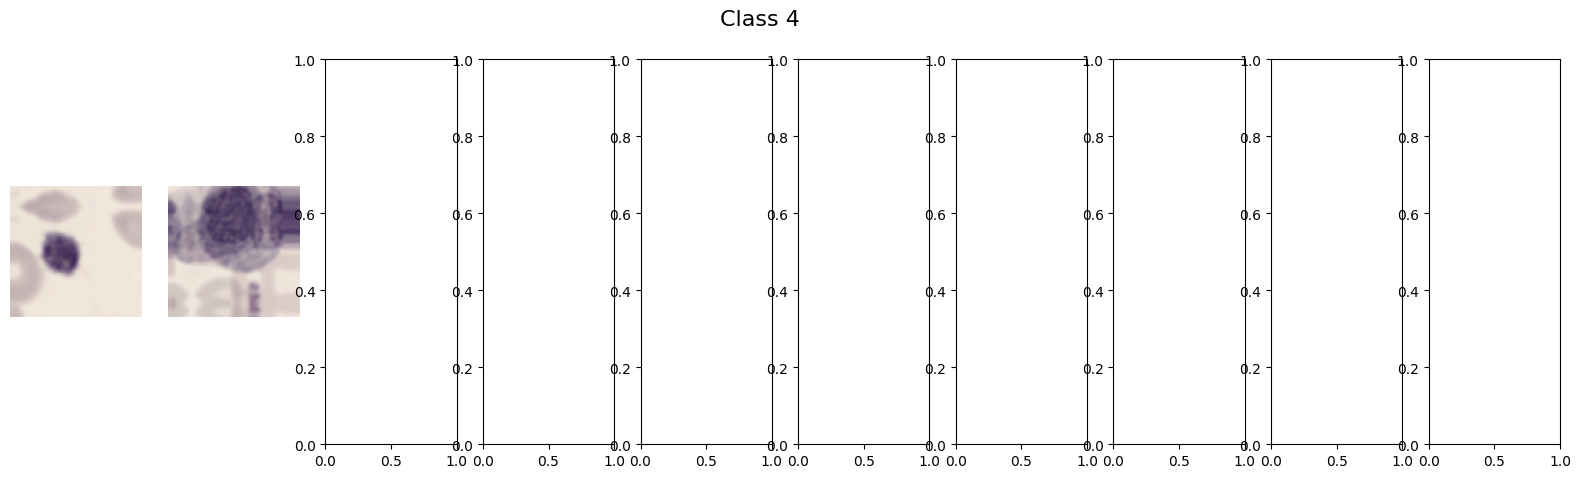

In [ ]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

def PlotRandomlyAugmentedImages(dataset_path, images_per_class=10, apply_augmentation=True):
    """
    Randomly selects images from the dataset, applies augmentations if enabled, and plots them.

    Args:
    - dataset_path (str): Path to the dataset file (.npz).
    - images_per_class (int): Number of images to display per class.
    - apply_augmentation (bool): If True, applies augmentation; otherwise, plots original images.
    """
    # Load dataset
    data = np.load(dataset_path)
    X = data['images']
    y = data['labels'].flatten()

    # Get unique classes
    unique_classes = np.unique(y)
    class_indices = {class_label: np.where(y == class_label)[0] for class_label in unique_classes}

    print("\nApplying augmentations and plotting images for each class...")
    for class_label in unique_classes:
        # Randomly select images_per_class images from the class
        selected_indices = random.sample(list(class_indices[class_label]), images_per_class)
        selected_images = X[selected_indices]
        selected_labels = [class_label] * images_per_class

        fig, axes = plt.subplots(1, images_per_class, figsize=(20, 5))
        fig.suptitle(f"Class {class_label}", fontsize=16)

        for i, (img, label) in enumerate(zip(selected_images, selected_labels)):
            if apply_augmentation:
                # Convert the image to a tensor
                img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

                # Select two images for augmentation
                selected_indices = random.choices(range(len(X)), k=2)
                selected_images = [data_augmentation(tf.convert_to_tensor(X[idx], dtype=tf.float32)).numpy() for idx in selected_indices]
                selected_images = tf.stack(selected_images, axis=0)
                selected_labels = tf.one_hot([class_label] * 2, depth=len(unique_classes))

                # Apply CutMix or MixUp
                augmented_samples = cutmix_or_mixup(selected_images, selected_labels)
                cutmix_image = augmented_samples["images"][0].numpy()

                # Final augmented image
                img_to_plot = data_augmentation(tf.convert_to_tensor(cutmix_image, dtype=tf.float32)).numpy()
            else:
                # Use the original image
                img_to_plot = img

            # Plot the image
            axes[i].imshow(img_to_plot.astype(np.uint8))
            axes[i].axis("off")

        plt.show()

# Paths
dataset_path = '/content/drive/MyDrive/Homework1/dataset/npz_NoTestSet/filtered_classes_noOutliears/train_set.npz'

# Call the function
PlotRandomlyAugmentedImages(dataset_path, images_per_class=10, apply_augmentation=True)  # Set False to skip augmentation


# Show class distribution

Show class distribution to check balancing

Available keys in the archive: ['images', 'labels']
(18640, 96, 96, 3)


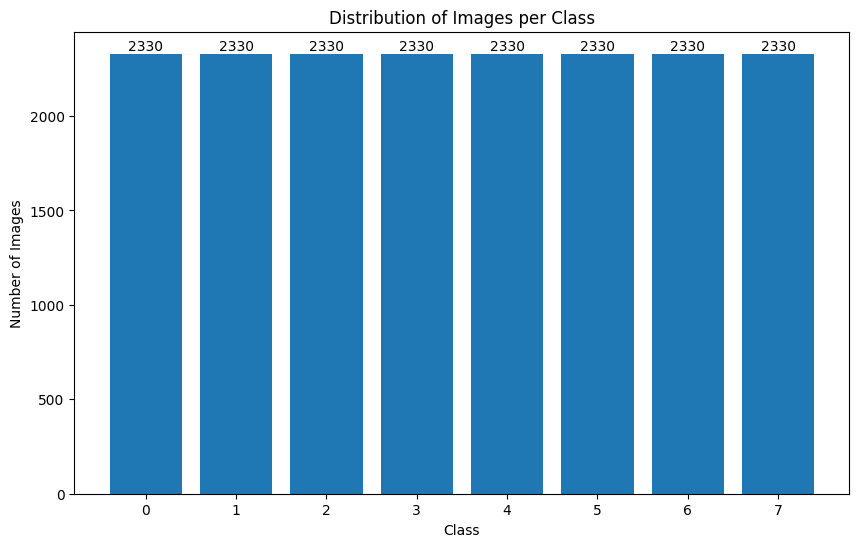

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_class_distribution(dataset_path):
    # Load the data from the .npz file
    data = np.load(dataset_path)
    print(f"Available keys in the archive: {data.files}")
    X = data['images']
    y = data['labels'].flatten()

    print(X.shape)

    # Calculate the distribution of each class
    unique, counts = np.unique(y, return_counts=True)
    class_distribution = dict(zip(unique, counts))

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_distribution.keys(), class_distribution.values())
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title("Distribution of Images per Class")
    plt.xticks(ticks=unique)  # Ensures each class is labeled on the x-axis

    # Add counts above each bar
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 str(count), ha='center', va='bottom')

    plt.show()

input_folder = '/content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/train_set_Unified.npz'

show_class_distribution(input_folder)
